# Using SpecpolFlow: Example $\xi^1$ CMa (HD 46328)

<img src="https://github.com/folsomcp/specpolFlow/blob/main/tutorials/OneObservationFlow_tutorialfiles/diagram4.png?raw=true" align: center width="1000px">



In the below code, we will walk through how to use [SpecpolFlow](https://github.com/folsomcp/specpolFlow) (with the use of [LSDpy](https://github.com/folsomcp/LSDpy)) with the spectra and polarization data of the magnetic B star $\xi^1$ CMa (HD 46328; [Erba et al. 2021](https://doi.org/10.1093/mnras/stab1454); ESPaDOnS). The code has the following structure:
1. Star Selection
2. Import packages
3. Creating the LSD Line Mask
4. Cleaning Line Mask
5. Creating LSD Profile
6. Extracting $B_{\text{z}}$

For additional information on the uses and outputs of either code, please consult their respective GitHubs linked above.

## 1. Star Selection
0. To use this tutorial, you must start with a normalized spectrum (.s file). If you do not have a .s file (you have .fits or .p files), please see the normalization tool [normPlot](https://github.com/folsomcp/normPlot).
1. Collect .s file. For this example, we provide the file (hd46328_test_1.s;ObsId: 2378216p). 
2. Collect important stellar parameters ($T_{\text{eff}}$, log $_g$ , $v\sin i$, observation specific radial velocities). These are provided below: 
    * $T_{\text{eff}} = 27000$ K
    * $\log g = 3.5$ (cgs)
    * $v\sin i  = 15$ km $\text{s}^{-1}$
    * $\text{RV} = 12$ km $\text{s}^{-1}$
3. Next we will need to obtain a list of atomic and molecular transition parameters for $\xi^1$ CMa from the Vienna Atomic Line Database (VALD; [Ryabchikova et al. 2015](https://ui.adsabs.harvard.edu/abs/2015PhyS...90e4005R/abstract)). The long list for this star is provided (LongList_T27000G35.dat), however, to retrieve a VALD long list, one can click the "Extract Stellar" button on the [VALD website](http://vald.astro.uu.se/).  Note that you need to register an email to access the site. The following input was used to obtain the example long list:
    * Starting wavelength: 3700  $\text{\AA}$
    * Ending wavelength: 9000  $\text{\AA}$
    * Detection threshold: 0.01 (line depths shallower than this threshold are not included)
    * Microturbulence: 2 km $\text{s}^{-1}$
    * $T_{\text{eff}} = 27000$ K
    * $\log g = 3.5$ (cgs)
    * Chemical Composition: 0.0 [Fe/H] (Solar)
    * Long format
    * Linelist configuration: Default

The long list file is a text file consisting of a header line containing information on the wavelength range of the list, as well as other information about the content of the file. Each spectral line has four rows of information in the file: the first row contains the most relevant information for making the mask, but the format is rather unpleasant to use. The line mask has a much more simplistic format that makes it easier to parse and manipulate. Additionally, the line mask calculates the effective Landé factor for each of the lines. 
    

   

## 2. Importing Necessary Packages
Now that all the outside data (.s and .dat files) has been obtained, the process of extracting the Bz can begin. The below block of code may output text such as "loading specpolFlow package" or "loading LSDpy package"; this an indication the packages are loading. If these messages do not appear, the packages may already be imported.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import astropy.units as u
import astropy.constants as const
import specpolFlow as pol
import LSDpy

## 3. Creating LSD Line Mask

To convert the VALD long list into a mask, one needs to call the `make_mask` function using the .dat long list. The user will need to specify the location and name of the output file, `depthCutoff`, and `atomsOnly` (`atomsOnly` = True excludes H lines). This will create a .mask file.

In [11]:
file_name = 'OneObservationFlow_tutorialfiles/LongList_T27000G35.dat'
file_output = 'OneObservationFlow_tutorialfiles/test_output/T27000G35_depth0.02.mask'
mask = pol.make_mask(file_name, file_output, depthCutoff = 0.02, atomsOnly = True)

spectrum = 'OneObservationFlow_tutorialfiles/hd46328_test_1.s'

missing Lande factors for 160 lines (skipped) from:
['He 2', 'O 2']
skipped all lines for species:
['H 1']


## 4. Cleaning Line Mask 
Next, we remove sections in the mask that we do not want affecting the LSD profile. These include regions 100 km $\text{s}^{-1}$ (specific to this example) around the Balmer series and Balmer gap, around the H-jump, and in areas of telluric contamination. We remove these sections because the lines are either of the wrong shape or the data is contaminated by the atmosphere; both would negativley effect later processing.

First, one can exclude the Balmer and telluric regions using `get_Balmer_regions_default` and  `get_telluric_regions_default`. The `get_Balmer_regions_default` function takes in the velocity region you wan to exclude. Then the `mask.clean` removes the lines within regions specified earlier. The clean mask can now be output to a new `.mask` file using `mask.save`.



In [3]:
# inputs
# user manual for telleric regions
velrange = 400 # units are in km/s
excluded_regions = pol.get_Balmer_regions_default(velrange) + pol.get_telluric_regions_default()
excluded_regions

In [4]:
# visualization of excluded regions
pd.DataFrame(excluded_regions.to_dict())

,start,stop,type
0,655.405353,657.156647,Halpha
1,485.491365,486.788635,Hbeta
2,433.470866,434.629134,Hgamma
3,409.622728,410.717272,Hdelta
4,396.480287,397.539713,Hepsilon
5,360.000000,392.000000,Hjump
6,587.500000,592.000000,telluric
7,627.500000,632.500000,telluric
8,686.000000,705.300000,telluric
9,717.000000,735.000000,telluric


In [5]:
# location of the output file
clean_Mask_filename = 'OneObservationFlow_tutorialfiles/test_output/hd46328_test_depth0.02_clean.mask'

# run cleanMask fuction and save
mask.clean(excluded_regions).save(clean_Mask_filename)

## 5. Create LSD Profile
Least-Squares Deconvolution (LSD) is a cross-correlation technique for computing the weighted average of selected spectral lines ([Donati et al. 1992](https://ui.adsabs.harvard.edu/abs/1997MNRAS.291..658D/abstract)). From [LSDpy](https://github.com/folsomcp/LSDpy), we use the default conditions:
* normDepth = 0.2 — normalized line depth
* normLande = 1.2 — normalized effective Lande factor
* normWave = 500.0 — normalized wavelength
* removeContPol = 1 — flag for whether the continuum polarization is subtracted from the LSD profile (0 = no, 1 = yes)
* trimMask = 0 — flag for whether very closely spaced lines should be removed from the line mask (0 = no, 1 = yes)
* sigmaClipIter = 0 — number of iterations for sigma clipping, rejecting possible pad pixels based on the fit to Stokes I
* sigmaClip = 500 — if sigma cliping, reject pixels where the observation differs from the model by more than this number of sigma
* interpMode = 1 — mode for interpolating the model on to the observation during LSD (0 = nearest neighbor, 1 = linear interpolation)

To capture the entire line profile, the range of the LSD profile is set to be 100 km $s^{-1}$ for this star. Additionally, the pixel size should be set relative to the resolution of the original data; for ESPaDOnS data, one should not go below $2.6$ km/s per pixel. In a case where the line profile is very broad, it may be advantageous to use larger pixels but make sure the profile has enough data. For our example, we use the ESPaDOnS lower threshold of $2.6$ km $s^{-1}$ per pixel.

To calculate the LSD profile, we call the `run_lsdpy` function, specify the file (.s file) and mask (.mask file). In the below code, we also input a name and location of the outfile (.lsd). For all outputs from this function and additional information on the utilities of the LSD class, see [LSDpy](https://github.com/folsomcp/LSDpy).

Average observed spec velocity spacing: 1.808983 km/s
using a 78 point profile with 2.600000 km/s pixels
mean mask depth 0.097107 wl 493.176 Lande 1.181456 (from 1091 lines)
mean mask norm weightI 0.485536 weightV 0.462642
saving model spectrum to  ...
I reduced chi2 251.8659 (chi2 19360931.36 constraints 76948 dof 78)
 Rescaling error bars by: 15.870283
V reduced chi2 1.1309 (chi2 86935.58 constraints 76948 dof 78)
 Rescaling error bars by: 1.063458
 removing profile continuum pol: -7.4182e-06 +/- 7.8412e-09 (avg err 8.8233e-05)
N1 reduced chi2 1.1034 (chi2 84817.45 constraints 76948 dof 78)
 Rescaling error bars by: 1.050423
 removing profile continuum pol: 1.1364e-07 +/- 7.6501e-09 (avg err 8.7151e-05)
(possible Stokes I uncertainty underestimate 2.0900e-03 vs 1.3697e-03)
line range estimate -14.200000000000188 42.99999999999969 km/s
V in line reduced chi^2 73.209971 (chi2 1610.619359) 
 detect prob 1.000000 (fap 0.000000e+00)
 Detection! V (fap 0.000000e+00)
 V outside line reduced

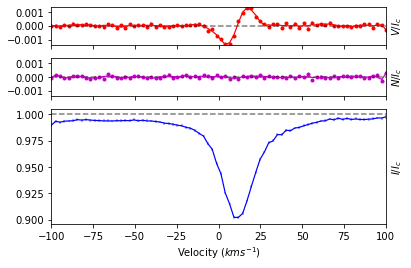

In [6]:
outfile = 'OneObservationFlow_tutorialfiles/test_output/hd46328_test_1.lsd'

lsd, mod = pol.run_lsdpy(obs = spectrum, mask = clean_Mask_filename, outName = outfile, 
           velStart =- 100.0, velEnd = 100.0, velPixel = 2.6, 
           normDepth = 0.2, normLande = 1.2, normWave = 500.0)

## 6. Calculate $B_z$ from LSD Profile

To calculate Bz we will be using the `lsd.calc_bz` function which takes in the following:
* cog - the center of gravity; this can either be set manually or calculated from one of the built in functions below
    * I (from Stokes I)
    * IV (from Stokes I times V)
    * V (from Stokes V)
    * min (minimum of profile)
* velrange - the total range over which will be considered in the Bz calculation; this includes the line itself as well as a little extra on either side
* plot - a flag that determines if an output plot will be automatically generated
* bzwidth - the range over which the Bz will be calculated; this should just include the line itself (if given a single number it will center the range on the cog value)

In the first example we are manually setting the velocity range and Bz width, however it is often useful to set the velocity range slightly larger than the $v\sin i$ and shifted to be centered on the cog value. By these standards, for this example, velrange _*would*_ be `velrange=[12-1.5*vsini,12+1.5*vsini]` and bzwidth _*would*_ be `bzwidth=vsini`. 

In the second example the cog value is being set automatically using the I method. 

The function will then output a dictionary with the following outputs:
* Ic: continuum value used for normalization
* Cog: the center of gravity value
* Bzwidth min (km $s^{-1}$): lower bound of the Bz width
* Bzwidth max (km $s^{-1}$): upper bound of Bz width
* V bz (G): Bz calculated from Stokes V profile
* V bz sig (G): standard deviation
* V FAP: false alarm probability [FAP (Donati et al. 1997)](https://ui.adsabs.harvard.edu/abs/1997MNRAS.291..658D/abstract). Definite detection (DD) is defined as having a FAP $< 10^{-5}$. A non-detection (ND) is defined as having a FAP $> 10^{-3}$. FAPs between $10^{-5}$ and $10^{-3}$ are defined as a marginal detection (MD).
* Null calculations - N1 and N2 are two different methods for null profile calculations; N1 is most commonly used.
    * N1 bz (G): Bz calculated from the Null 1 profile
    * N1 bz sig (G): standard deviation
    * N1 FAP: false alarm probability of Null 1 Bz measurement
    * N2 bz (G): Bz calculated from the Null 2 profile
    * N2 bz sig (G): standard deviation
    * N2 FAP: false alarm probability of Null 2 Bz measurement
    
To see additional capabilities of the Bz function, see [SpecpolFlow](https://github.com/folsomcp/specpolFlow) or for a more detailed tutorial, see the [Bz tutorial](https://github.com/folsomcp/specpolFlow/blob/main/tutorials/CalculateBz.ipynb).

using AUTO method for the normalization
  using the median of the continuum outside of the line


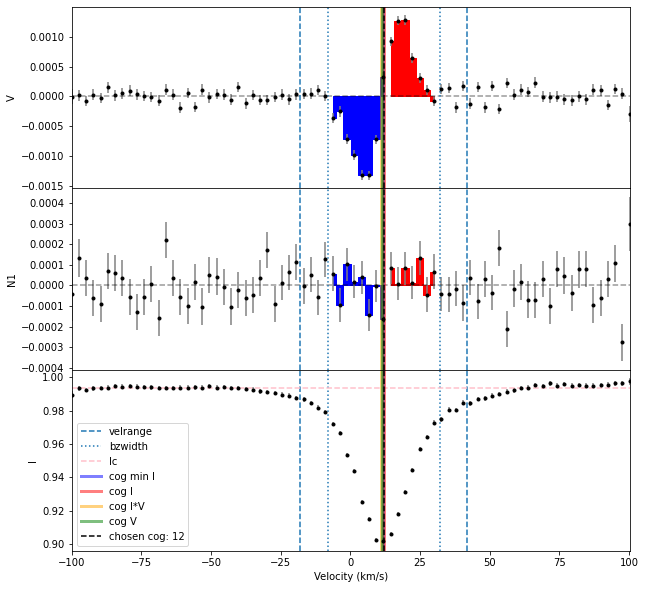

In [7]:
# Bz calculation using manual cog selection
vrad = 12
velrange = [-18,42] # the velocity range over which the center line is found
bzwidth = 20 # this is the width about the center line used to calculate Bz

lsd = pol.read_lsd(outfile)
Bz, fig = lsd.calc_bz(cog = vrad, velrange = velrange, plot = True, bzwidth = bzwidth)

In [8]:
# the below dataframe contains the defaults outputs
pd.DataFrame(data=[Bz])

,Ic,cog,Bzwidth min,Bzwidth max,V bz (G),V bz sig (G),V FAP,N1 bz (G),N1 bz sig (G),N1 FAP,N2 bz (G),N2 bz sig (G),N2 FAP
0,0.993659,12,-8,32,-112.769454,5.41078,0.0,-3.826854,5.302269,0.264093,0.0,0.0,0.0


using AUTO method for the normalization
  using the median of the continuum outside of the line


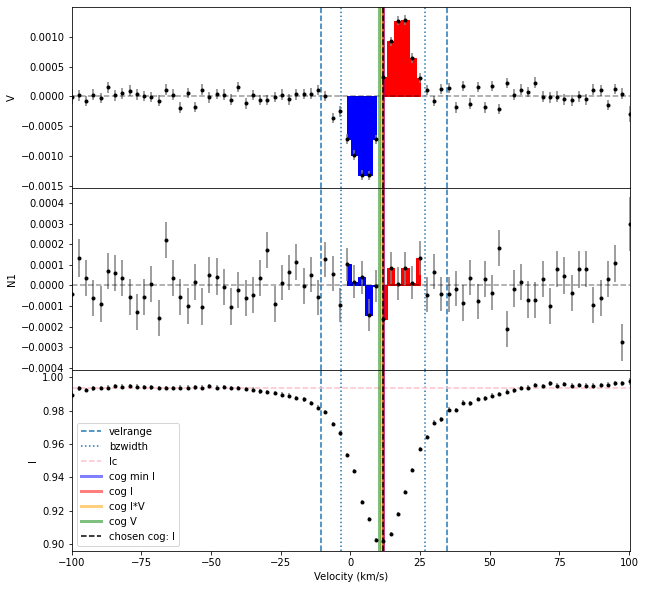

In [9]:
# Bz calculation using automatic cog selection (I)
vsini = 15
vrad = 12

lsd = pol.read_lsd(outfile)
Bz, fig = lsd.calc_bz(cog = 'I', velrange = [(vrad-1.5*vsini),(vrad+1.5*vsini)], plot = True, bzwidth = vsini)

In [10]:
pd.DataFrame(data=[Bz])

,Ic,cog,Bzwidth min,Bzwidth max,V bz (G),V bz sig (G),V FAP,N1 bz (G),N1 bz sig (G),N1 FAP,N2 bz (G),N2 bz sig (G),N2 FAP
0,0.993591,11.733321,-3.266679,26.733321,-105.859098,3.903609,0.0,-2.611896,3.805383,0.172609,0.0,0.0,0.0
